<h3><center>Pre-processing</center></h3>

In [1]:
#Inports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import numpy as np
from PIL import Image
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, ReLU
from keras.models import Model
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from numpy import random
import tensorflow as tf
from random import randint
import keras
from keras_preprocessing import image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from skimage.transform import resize
from skimage.morphology import label
from pycocotools import mask as maskUtils
from tqdm import tqdm
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import itertools
import argparse
from glob import glob

In [2]:
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

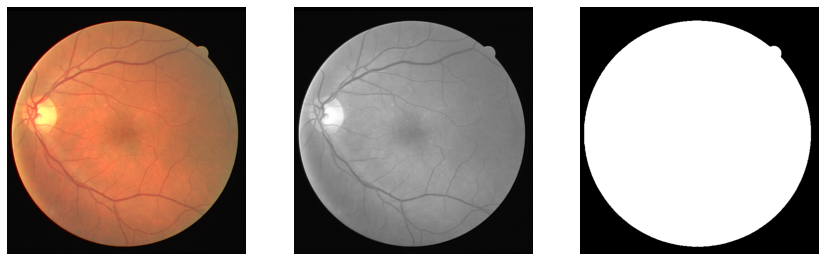

In [3]:
img = cv2.imread('path-to-your-dataset-here/datasets/training/images/21_training.tif')
mask = plt.imread('path-to-your-dataset-here/datasets/training/mask/21_training_mask.gif') #cause cv2 can't read gifs :X
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

plot_images(rgb, gray, mask)

<h3><center>U-Net</center></h3>

In [4]:
input_shape = (64, 64)

def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))/255.
    return x[..., np.newaxis]


def random_crop(img, mask, crop_size=input_shape[0]):
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    i = randint(0, imgheight-crop_size)
    j = randint(0, imgwidth-crop_size)

    return img[i:(i+crop_size), j:(j+crop_size), :], mask[i:(i+crop_size), j:(j+crop_size)]


def gen(data):
    while True:
        repeat = 4
        index= random.choice(list(range(len(data))), batch_size//repeat)
        index = list(map(int, index))
        list_images_base = [read_input(data[i][0]) for i in index]
        list_gt_base = [read_gt(data[i][1]) for i in index]

        list_images = []
        list_gt = []

        for image, gt in zip(list_images_base, list_gt_base):

            for _ in range(repeat):
                image_, gt_ = random_crop(image.copy(), gt.copy())
                list_images.append(image_)
                list_gt.append(gt_)

        yield np.array(list_images), np.array(list_gt)

<h3><center>U-Net Architecture</center></h3>

In [5]:
def get_unet(do=0, activation=ReLU):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(inputs)))#64
    conv1 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv1)))#64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(pool1)))#128
    conv2 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv2)))#128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(pool2)))#256
    conv3 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv3)))#256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(pool3)))#512
    conv4 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv4)))#512
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(pool4)))#1024
    conv5 = Dropout(do)(activation()(Conv2D(512, (3, 3), padding='same')(conv5)))#1024

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)#512
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(up6)))#256
    conv6 = Dropout(do)(activation()(Conv2D(256, (3, 3), padding='same')(conv6)))#256

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)#256
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(up7)))#128
    conv7 = Dropout(do)(activation()(Conv2D(128, (3, 3), padding='same')(conv7)))#128

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)#128
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(up8)))#64
    conv8 = Dropout(do)(activation()(Conv2D(64, (3, 3), padding='same')(conv8)))#64

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)#64
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(up9)))#32
    conv9 = Dropout(do)(activation()(Conv2D(32, (3, 3), padding='same')(conv9)))#32

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics=['accuracy'])


    return model

<h3><center>Train Model</center></h3>

In [6]:
batch_size = 16
activation = globals()["ReLU"]
dropout = 0.3

train_data = np.array(list(zip(sorted(glob('path-to-your-dataset-here/datasets/training/images/*.tif')),
                      sorted(glob('path-to-your-dataset-here/datasets/training/1st_manual/*.gif')))))


test_data = np.array(list(zip(sorted(glob('path-to-your-dataset-here/datasets/test/images/*.tif')),
                      sorted(glob('path-to-your-dataset-here/datasets/test/1st_manual/*.gif')))))

model = get_unet(do=dropout, activation=activation)
history = model.fit_generator(gen(train_data), epochs=30, validation_data=gen(test_data), validation_steps=100*3//batch_size,
                            steps_per_epoch= 100*len(train_data)//batch_size)

/Users/markndipenoch/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/markndipenoch/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
125/125 [==============================] - 88s 695ms/step - loss: 0.3512 - accuracy: 0.8912 - val_loss: 0.2908 - val_accuracy: 0.9012
Epoch 2/30
125/125 [==============================] - 87s 697ms/step - loss: 0.3189 - accuracy: 0.8918 - val_loss: 0.2757 - val_accuracy: 0.8973
Epoch 3/30
125/125 [==============================] - 87s 695ms/step - loss: 0.2393 - accuracy: 0.9140 - val_loss: 0.2269 - val_accuracy: 0.9234
Epoch 4/30
125/125 [==============================] - 88s 709ms/step - loss: 0.1847 - accuracy: 0.9353 - val_loss: 0.1907 - val_accuracy: 0.9347
Epoch 5/30
125/125 [==============================] - 83s 663ms/step - loss: 0.1647 - accuracy: 0.9421 - val_loss: 0.1538 - val_accuracy: 0.9463
Epoch 6/30
125/125 [==============================] - 83s 664ms/step - loss: 0.1544 - accuracy: 0.9455 - val_loss: 0.1776 - val_accuracy: 0.9411
Epoch 7/30
125/125 [==============================] - 85s 677ms/step - loss: 0.1516 - accuracy: 0.9459 - val_loss: 0.2353 - val_ac

<h3><center>Save Trained Model</center></h3>

In [7]:
model.save_weights("final.hdf5")

In [8]:
batchsize = 4
input_shape = (576, 576)

def batch(iterable, n=batchsize):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


def read_input(path):
    x = np.array(Image.open(path))/255.
    return x


def read_gt(path):
    x = np.array(Image.open(path))
    return x[..., np.newaxis]/np.max(x)
  
  
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

<h3><center>Load Trained Model</center></h3>

In [9]:
model.load_weights("final.hdf5")

<h3><center>Load Test Data</center></h3>

In [10]:
val_data = list(zip(sorted(glob('path-to-your-dataset-here/datasets/test/images/*.tif')),
                          sorted(glob('path-to-your-dataset-here/datasets/test/1st_manual/*.gif')),
                        sorted(glob('path-to-your-dataset-here/datasets/test/mask/*.gif'))))

<h3><center>Predict on Test Data</center></h3>

In [11]:
gt_list = []
pred_list = []

for batch_files in batch(val_data):

    imgs = [resize(read_input(image_path[0]), input_shape) for image_path in batch_files]
    seg = [read_gt(image_path[1]) for image_path in batch_files]
    mask = [read_gt(image_path[2]) for image_path in batch_files]

    imgs = np.array(imgs)

    pred = model.predict(imgs)

    pred_all = (pred)

    pred = np.clip(pred, 0, 1)

    for i, image_path in enumerate(batch_files):

        pred_ = pred[i, :, :, 0]

        pred_ = resize(pred_, (584, 565))

        mask_ = mask[i]

        gt_ = (seg[i]>0.5).astype(int)

        gt_list += gt_.flatten().tolist()
        pred_list += pred_.flatten().tolist()

        pred_ = 255.*(pred_ - np.min(pred_))/(np.max(pred_)-np.min(pred_))
        #plot_images(read_input(image_path[0]), pred_, read_input(image_path[1]))


print(len(gt_list), len(pred_list))
print("AUC ROC : ", roc_auc_score(gt_list, pred_list))

6599200 6599200
AUC ROC :  0.9783066388547638


<h3><center>Confusion Matrix with Simple Classification</center></h3>

In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

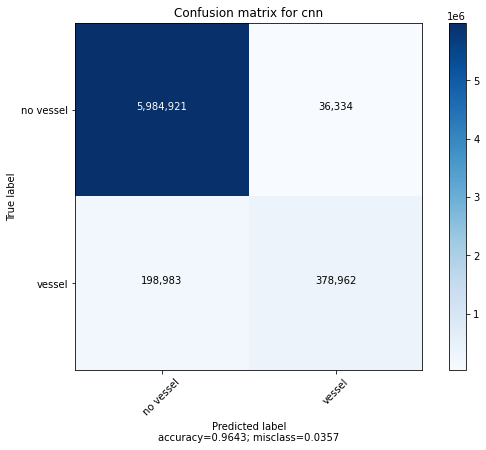

In [13]:
pred_arr = np.array(pred_list)
pred_arr[pred_arr >= 0.5] = 1
pred_arr[pred_arr <0.5] = 0
cm = confusion_matrix(np.array(gt_list),pred_arr)

plot_confusion_matrix(cm=cm, target_names=['no vessel', 'vessel'], normalize=False,
                      title='Confusion matrix for cnn')

<h3><center>ROC Plot for Simple Classification</center></h3>

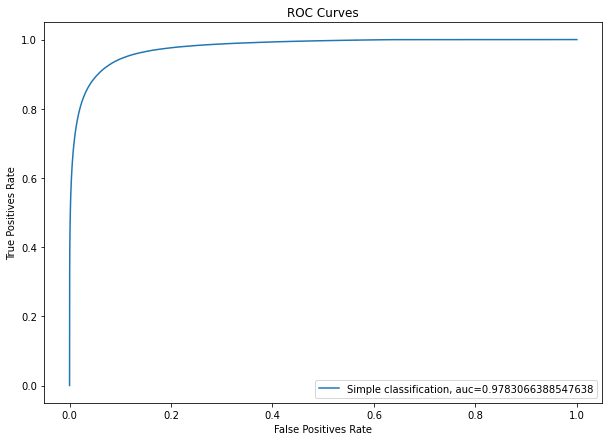

In [14]:
fpr, tpr, _ = roc_curve(gt_list,pred_list)
auc = roc_auc_score(gt_list,pred_list)
plt.figure(figsize=(10,7))
plt.plot(fpr,tpr,label="Simple classification, auc="+str(auc))
plt.legend(loc=4)
plt.title('ROC Curves')
plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')
plt.show()

In [15]:
[tn, fp], [fn, tp] = cm

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1score = 2*precision*sensitivity / (sensitivity + precision)

print("sensitivity: ", sensitivity)
print("specificity: ", specificity)
print("precision: ", precision)
print("f1score: ", f1score)

sensitivity:  0.6557059927847806
specificity:  0.9939657098063444
precision:  0.9125105948528278
f1score:  0.7630816690007762
